In [1]:
from split_data import split
import numpy as np
import torch
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from utils import *


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device}")

Using mps


In [3]:
source_path = "../Data/Augmentation/Potato"
training_path = "../train_data/Potato"
testing_path = "../test_data/Potato"
train_test_ratio = 0.7
split(source_path, training_path, testing_path, train_test_ratio) 

Finish splitting No_leaves
[Training Samples:800, Testing Samples:343]   Original Samples:1143
---------------------
Finish splitting Late_blight
[Training Samples:700, Testing Samples:300]   Original Samples:1000
---------------------
Finish splitting Healthy
[Training Samples:700, Testing Samples:300]   Original Samples:1000
---------------------
Finish splitting Early_blight
[Training Samples:700, Testing Samples:300]   Original Samples:1000
---------------------
Total Training Samples: 2900, Testing Samples: 1243, Total Samples: 4143


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


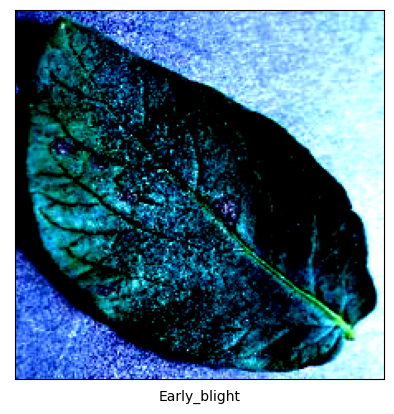

In [4]:
# -------------[transform into suitable size for transfer learning]--------------------
transformation = preprocess()

train_dataset = ImageFolder(training_path, transform = transformation)

test_dataset = ImageFolder(testing_path,transform = transformation)

classes = train_dataset.classes

#display the first image in the dataset
display_img(*train_dataset[0], classes)

In [5]:
batch_size = 64
train_val_ratio = 0.8
val_size = int(np.round(len(train_dataset) * (1-train_val_ratio)))
train_size = len(train_dataset) - val_size 

train_data, val_data = random_split(train_dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size, num_workers = 4, pin_memory = True)

test_dl = DataLoader(test_dataset, batch_size, num_workers = 4, pin_memory = True)

Length of Train Data : 2320
Length of Validation Data : 580


### EfficintModel B0

In [6]:
efficient_model = load_efficient_net().to(device)

num_classes = len(classes)

efficient_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficient_model.parameters(), lr=0.001)

# efficientNet B0 model
efficient_results = train(model=efficient_model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

torch.save(efficient_model, "../Models/potato_efficient_model.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6546 | train_acc: 0.8687 | train_f1: 0.8659 | val_loss: 0.2366 | val_acc: 0.9859 | val_f1: 0.9845 | 
--------------------------------------------------------------
Epoch: 2 | train_loss: 0.2011 | train_acc: 0.9764 | train_f1: 0.9772 | val_loss: 0.1284 | val_acc: 0.9859 | val_f1: 0.9845 | 
--------------------------------------------------------------
Epoch: 3 | train_loss: 0.1393 | train_acc: 0.9797 | train_f1: 0.9793 | val_loss: 0.0931 | val_acc: 0.9875 | val_f1: 0.9862 | 
--------------------------------------------------------------
Epoch: 4 | train_loss: 0.1044 | train_acc: 0.9844 | train_f1: 0.9853 | val_loss: 0.0803 | val_acc: 0.9875 | val_f1: 0.9862 | 
--------------------------------------------------------------
Epoch: 5 | train_loss: 0.0876 | train_acc: 0.9848 | train_f1: 0.9858 | val_loss: 0.0649 | val_acc: 0.9859 | val_f1: 0.9845 | 
--------------------------------------------------------------
Epoch: 6 | train_loss: 0.0726 | train_acc: 0.9894 | tra

In [7]:
# accuracy for efficientNet b0
if torch.backends.mps.is_available():
    efficient_model = torch.load("../Models/potato_efficient_model.pt", map_location=torch.device('mps'))
elif torch.cuda.is_available():
    efficient_model = torch.load("../Models/potato_efficient_model.pt", map_location=torch.device('cuda'))
    
efficient_report = test_run(efficient_model, test_dl, device, batch_size, classes)
print(efficient_report)

              precision    recall  f1-score   support

Early_blight       0.98      0.99      0.99       300
     Healthy       0.99      1.00      1.00       300
 Late_blight       0.99      0.96      0.98       300
   No_leaves       1.00      1.00      1.00       343

    accuracy                           0.99      1243
   macro avg       0.99      0.99      0.99      1243
weighted avg       0.99      0.99      0.99      1243



### MobileV2 Model

In [8]:
mobile_model = load_mobile_net().to(device)

mobile_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobile_model.parameters(), lr=0.001)

# MobileNet V2 model
mobile_results = train(model=mobile_model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

torch.save(mobile_model, "../Models/potato_mobile_model.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7468 | train_acc: 0.8505 | train_f1: 0.8513 | val_loss: 0.3469 | val_acc: 0.9844 | val_f1: 0.9828 | 
--------------------------------------------------------------
Epoch: 2 | train_loss: 0.2558 | train_acc: 0.9709 | train_f1: 0.9703 | val_loss: 0.1939 | val_acc: 0.9844 | val_f1: 0.9828 | 
--------------------------------------------------------------
Epoch: 3 | train_loss: 0.1649 | train_acc: 0.9818 | train_f1: 0.9815 | val_loss: 0.1332 | val_acc: 0.9922 | val_f1: 0.9914 | 
--------------------------------------------------------------
Epoch: 4 | train_loss: 0.1244 | train_acc: 0.9840 | train_f1: 0.9836 | val_loss: 0.1056 | val_acc: 0.9969 | val_f1: 0.9966 | 
--------------------------------------------------------------
Epoch: 5 | train_loss: 0.0988 | train_acc: 0.9840 | train_f1: 0.9849 | val_loss: 0.0895 | val_acc: 0.9953 | val_f1: 0.9948 | 
--------------------------------------------------------------
Epoch: 6 | train_loss: 0.0913 | train_acc: 0.9848 | tra

In [9]:
# MobileNet V2 accuracy
if torch.backends.mps.is_available():
    mobile_model = torch.load("../Models/potato_mobile_model.pt", map_location=torch.device('mps'))
elif torch.cuda.is_available():
    mobile_model = torch.load("../Models/potato_mobile_model.pt", map_location=torch.device('cuda'))
    

mobile_report = test_run(mobile_model, test_dl, device, batch_size, classes)
print(mobile_report)

              precision    recall  f1-score   support

Early_blight       0.99      0.99      0.99       300
     Healthy       0.99      0.99      0.99       300
 Late_blight       0.98      0.98      0.98       300
   No_leaves       1.00      1.00      1.00       343

    accuracy                           0.99      1243
   macro avg       0.99      0.99      0.99      1243
weighted avg       0.99      0.99      0.99      1243



### Predicting Singel Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


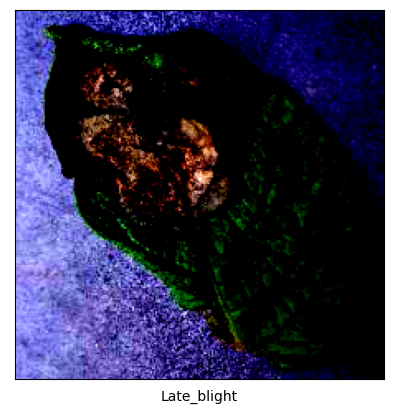

In [10]:
from PIL import Image
test_img_path = "/Users/afflatus/Documents/UoM_MSc/Diss/test_data/Potato/Late_blight/image (26).JPG"

img = Image.open(test_img_path)


img1 = transformation(img)

display_img(img1, predict(mobile_model, test_img_path, device), classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


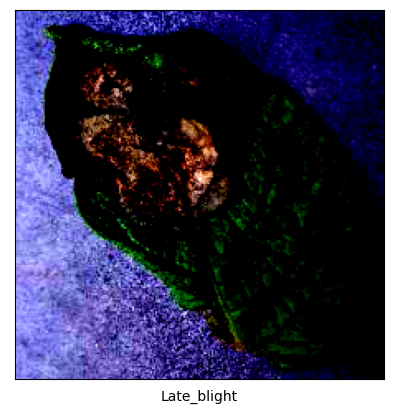

In [11]:
display_img(img1, predict(efficient_model, test_img_path, device), classes)